<div align="center">

---
# Connect-4 [Artificial Intelligence Project]
---
</div>

<div align="center">

***
## Problem Presentation
***
</div>
    
**Connect Four** is a **two-player strategy game** similar to tic-tac-toe. It is played using 42 tokens (21 red & 21 black) inside a grid of **7 columns by 6 rows** where both players take **turns**

A **player's move** consists of dropping one of his tokens into a column of his choice where it falls until it hits the bottom or the top token in that column. In addition, if the chosen column is **already full** then the player must choose another one.

A **player wins** by creating an arrangement in which at least **four of his tokens** are aligned in a **row**, **column** or **diagonal** (**ascending or descending**). Therefore if the **board is full with tokens** whilst not having formed any kind of arrangement, then the match results in a **Tie** between both players.

<div align="center">

---
## Search Problem Formulation
---
</div>


$\quad$To properly solve this Connect-4 Problem it's crucial to formulate it as **Search Problem**. As any other search problem it's important to take into consideration the following aspects:
- **State Representation**
- **Initial (Current) State**
- **Objective Test** (Determines the wanted states - Final States)
- **Action Space** (Actions - Defined by **Preconditions**, **Effects** and **Cost** on the Environment)
- **Solution Cost**

### State Representation
$\quad$Since our game is played upon a NxM grid we can consider it as a **Matrix**. In this matrix every position represents either the **presence** or the **absence** of a player's piece. In this case we considered:

    0 - Represents a Empty Space
    1 - Represents a Player 1's Piece
    2 - Represents a Player 2's Piece

### Initial (Current) State
$\quad$Initially the board is completely **Empty** which causes the NxM matrix to be entirely **filled with 0's**. Moreover, any other states can be considered as any possible board's configuration which means that they were accessed by making **valid moves** upon the initial state.

### Objective Test
$\quad$In order to determine if we've found a Objective State it's important to evaluate the current board's configuration. If it contains a **4-piece combination [Horizontal / Vertical Lines or Ascending / Ascending Diagonals]** from the **same type** then one of the player's won the game and we reached a final state. Otherwise the state isn't final unless the board is **totally full** which means that none of the players won.

### Action Space
$\quad$The **Action Space** contains all the possible moves that can be made into any board configuration columns as long as the column selected isn't full.

### Solution Cost
$\quad$Since any solution is composed by the path between the initial and final states, it's cost relies as the sum of all steps's cost. However, since each step costs 1, then the solution's cost becomes the total number of steps taken to solve the problem.

<div align="center">

---
## State Space [Class]
---
</div>
    
In this section we took into consideration the **implemention** of the game's state which will be later used by search algorithms in order to find a **solution to our problem**.

Since the **State Representation** can greatly impact the solution's effectiveness and efficiency, it's important to design it properly!

In [1]:
# Importing Dependencies
from Constants import  (NROWS, NCOLS, # Board's Size
                        SQSIZE, X_OFFSET, Y_OFFSET, BORDER_THICKNESS, WIDTH, HEIGHT, CIRCLE_OFFSET, CIRCLE_POS, CIRCLE_RADIUS, # Some Parameters for the Graphical User Interface
                        BLACK, WHITE, LIGHT_BLUE, BLUE, DARK_BLUE, RED, DARK_RED, GREEN, DARK_GREEN, PIECES_COLORS) # RGB Colors
import numpy as np
from copy import (deepcopy)
from time import (time)
from math import (sqrt, log)
import random as rd
from IPython.display import (clear_output) # Helps clear the output of cells without having to do it manually
import heapq
import tracemalloc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygame

pygame 2.5.2 (SDL 2.28.3, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [36]:
class Connect_Four_State:
    def __init__(self):
        # Matrix to Store the Board's Values
        self.board = np.zeros(shape=(NROWS, NCOLS), dtype=np.int8)

        # Array to keep track of the row's index for every column where a piece can be placed
        # Basically it's the Row idx for every column's height
        self.columns_height = np.full(shape=NCOLS, fill_value=(NROWS - 1), dtype=np.int8)

        # Defining the Possible Actions (Initially a piece can be placed in any column)
        self.actions = np.arange(NCOLS, dtype=np.int8)
        
        # Initializing a variable to track the current player
        self.current_player = 1
        
        # Variable to store the Winner (-1 - Game still running || 0 - Tie || 1 - PLayer 1 || 2 - Player 2 / AI)
        self.winner = -1
        
        # Setting a varible to store the board's move_history
        self.move_history = (self.board,)
    
    def next_player(self):
        # Returns the next turn's player
        return 3 - self.current_player

    def previous_player(self):
        # Returns the previous's player
        return self.next_player()
    
    def is_over(self):
        # If the Winner corresponds to -1 then the game is not finished otherwise it is
        return self.winner != -1
        
    def reset(self):
        # Calls back the Constructor
        return self.__init__()
    
    def inside_board(self, x, y):
        # Checks if a position (x,y) exists inside the board's matrix
        return (x >= 0 and x < NROWS) and (y >= 0 and y < NCOLS)
    
    def move(self, ncol):
        # The move is not valid
        if (ncol not in self.actions):
            return self

        # Creating a new state
        new_state = deepcopy(self)
        
        # Inserting the move into the board
        nrow = new_state.columns_height[ncol]
        new_state.board[nrow, ncol] = new_state.current_player
        
        # Updating the "ncol"'s height
        new_state.columns_height[ncol] -= 1
        
        # Checking if the column is full and therefore uncapable of receiving more pieces -> Changes the action space
        if (new_state.columns_height[ncol] < 0):
            new_state.actions = np.delete(new_state.actions, np.where(new_state.actions == ncol))

        # Updates the current Winner
        new_state.update_winner(nrow, ncol)

        # Updating current player for the next state
        new_state.current_player = new_state.next_player()

        # Updating move_history
        new_state.move_history = (*new_state.move_history, new_state.board)
        
        # Returns the New State
        return new_state

    def generate_new_states(self):
        # List to contain all the new states
        new_states = []

        # Iterates through all possible actions and creates a new state for each one
        for ncol in self.actions:
            new_states.append(self.move(ncol))

        # Returns all generated states
        return new_states
                
    def check_line(self, n, player, values):
        # -> Checks for a 4-piece line given 4 consecutive values from the matrix
        # Calculates the number of pieces from the value's array that are from the given player
        player_pieces = 0
        empty_pieces = 0

        for piece in values:
            if (piece == player):
                player_pieces += 1
            elif (piece == 0):
                empty_pieces += 1
        
        # Finds a Full 4-piece Line
        if n == 4:
            return player_pieces == 4
        
        # Finds a complete 3-piece Line
        if n == 3:
            # Checks if it's possible to make it a 4-piece Line by adding another
            return player_pieces == 3 and empty_places == 1
    
    def count_lines(self, n, player, nrow, ncol):
        # -> Searches the Board looking for a 4-piece Combination

        # Horizontal Line
        row = nrow
        counter = 0
        for col in range(NCOLS):
            if (self.board[row, col] == player):
                counter += 1
                if (counter == 4):
                    return True
            else:
                counter = 0

        # Vertical Line
        col = ncol
        counter = 0
        for row in range(NROWS):
            if (self.board[row, col] == player):
                counter += 1
                if (counter == 4):
                    return True
            else:
                counter = 0

        # Descending Diagonal Line
        col = ncol
        row = nrow
        counter = 0
        while row > 0 and col > 0:
            row -= 1
            col -= 1
        while row < NROWS and col < NCOLS:
            if (self.board[row, col] == player):
                counter += 1
                if (counter == 4):
                    return True
            else:
                counter = 0
            row += 1
            col += 1

        # Ascending Diagonal Line
        col = ncol
        row = nrow
        counter = 0
        while row < NROWS - 1 and col > 0:
            row += 1
            col -= 1
        while row >= 0 and col < NCOLS:
            if self.board[row, col] == player:
                counter += 1
                if counter == 4:
                    return True
            else:
                counter = 0
            row -= 1
            col += 1
            
        return False
    
    def update_winner(self, nrow, ncol):
        # -> Updates the Current State's Winner
        # Checks if the Board is full already
        if (self.actions.size == 0):
            self.winner = 0
            
        # Checks for a 4-piece combination made by PLayer 1 (after he made his move)
        elif(self.current_player == 1 and self.count_lines(4, 1, nrow, ncol)):
            self.winner = 1
            
        # Checks for a 4-piece combination made by PLayer 2 (after he made his move)
        elif(self.current_player == 2 and self.count_lines(4, 2, nrow, ncol)):
            self.winner = 2

    def read_state(self, file_path):
        # Reads a game state from a text file into a new game state
        new_state = Connect_Four_State()

        # Creating variables to keep track of the amount of each type of pieces
        pieces_1 = 0
        pieces_2 = 0

        # Reading the board from the text file
        with open(file_path, "r") as f:
            lines = [line.rstrip() for line in f]

        # Updates the Board Matrix
        for i in range(len(lines)):
            for j in range(len(lines[i])):
                if (lines[i][j] == '-'):
                    new_state.board[i, j] = 0
                elif (lines[i][j] == 'X'):
                    new_state.board[i, j] = 1
                    pieces_1 += 1
                elif (lines[i][j] == 'O'):
                    new_state.board[i, j] = 2
                    pieces_2 += 1

        # Updating the Column's Heights
        for nrow in range(len(lines)):
            for ncol in range(len(lines[nrow])):
                if (new_state.board[nrow][ncol] == 0):
                    continue
                elif(new_state.board[nrow][ncol] != 0):
                    if (new_state.inside_board(nrow - 1, ncol)):
                        new_state.columns_height[ncol] = nrow -1
                    else:
                        new_state.actions = np.delete(new_state.actions, np.where(new_state.actions == ncol))
                        break
        
        
        # Updates next player
        if (pieces_1 > pieces_2):
            new_state.current_player = 2
        else:
            new_state.current_player = 1

        # Updating move_history
        new_state.move_history = (*new_state.move_history, new_state.board)
        
        return new_state
    
    """ AUXILIAR METHODS """

    def __str__(self):
        # -> Converts the board into the style used in the Assignment 1 Paper
        DECODER = {0:'-', 1:'X', 2:'O'}
        line = ["-" for i in range(2*NCOLS -1)]
        line.insert(0, '#')
        line.insert(1, ' ')
        line.insert(len(line), ' ')
        line.insert(len(line), '#')
        formated_line = "".join(line)
        new_board = formated_line + '\n'
        for x in range (NROWS):
            for y in range (NCOLS):
                if (y == 0):
                    new_board += "| " + DECODER[self.board[x, y]]
                elif (y == NCOLS -1):
                    new_board += " " + DECODER[self.board[x, y]] + " |"
                else:
                    new_board += " " + DECODER[self.board[x, y]]
            new_board += '\n'
        new_board += formated_line
        return new_board
        
    def __hash__(self):
        return hash(str(self.board))

    def __eq__(self, other:object):
        if (not isinstance(other, Connect_Four_State)):
            raise Exception(f"Sorry, other object is not an instance of {self.__class__.__name__}")
        return hash(self) == hash(other)

In [3]:
game = Connect_Four_State()
print(game, "\n")

game = game.move(2)
game = game.move(2)
game = game.move(2)
game = game.move(2)
game = game.move(2)
game = game.move(2)
game = game.move(2)
print(game, "\n")

# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
# ------------- # 

# ------------- #
| - - O - - - - |
| - - X - - - - |
| - - O - - - - |
| - - X - - - - |
| - - O - - - - |
| - - X - - - - |
# ------------- # 



<div align="center">

---
## TreeNode [Class]
---
</div>

$\quad$In order to Implement the **Search Algorithms** we decided to create another additional class [TreeNode Class] in which the the State Class will be wrapped around with. This **TreeNode** class is defined with:

- **State** (Connec_Four_State Class)
- **Parent** (Reference to the Node's Parent)
- **Children** (List that contains all the New Nodes that can be obtained after the Current One)

$\quad$Moreover, it also contains other attributes that are focused on inside the **Monte Carlo Tree Search Algorithm's** Implementation such as:

- **Visits** (**Total of Visits** a Node Received))
- **Wins** (**Total Wins** a Node was capable to obtain after being subject to a **Rollout**)
- **Unexplored_Actions** (List with all the **Actions** that are yet to be considered inside the Algorithm - mostly used in the **Expansion Phase**)

In [4]:
class TreeNode:
    def __init__(self, state, parent=None):
        # Stores a State of the Game
        self.state = state
        # Keeps a reference to his Parent Node
        self.parent = parent
        # Stores all the generated nodes
        self.children = []
        # Initializing the number of visits [Used in the MCTS]
        self.visits = 0
        # Defining a variable to keep track of the amount of wins after choosing a certain node
        self.wins = 0
        # Declaring a variable to store all moves that were not yet explored
        self.unexplored_actions = self.state.actions.copy()

    def is_root(self):
        # Returns if the current node is the root
        return self.parent is None
    
    def is_leaf(self):
        # Returns the True if the Node does not have ny children and therefore is a leaf
        return len(self.children) == 0

    def is_terminal(self):
        # Returns if the current node contains a terminal node or not
        return self.state.is_over()

    def fully_expanded(self):
        # Returns True if a node is fully expanded
        return self.unexplored_actions.size == 0
    
    def pick_random_child(self):
        # Picking a random unexplored_action
        [ncol] = np.random.choice(self.unexplored_actions, size=1)
        # Creating a new node with the random action picked
        new_child = self.generate_new_node(ncol)
        # Returns the New Child
        return new_child
            
    def generate_new_node(self, ncol):
        # Creates a new state after the move
        new_state = self.state.move(ncol)
        # Wraps it with a TreeNode 
        new_node = TreeNode(state=new_state, parent=self)
        # Inserts the New Node into the Current Node's Children
        self.children.append(new_node)
        # Updating the unexplored actions
        self.unexplored_actions = np.delete(self.unexplored_actions, np.where(self.unexplored_actions == ncol))
        # Returns the generated Node
        return new_node

    def read_state_node(self, file_path):
        # Reading a State
        new_state = Connect_Four_State().read_state(file_path)
        # Creating a new node based on the read state
        new_node = TreeNode(state=new_state,parent=None)
        # Returning the new node
        return new_node

    def __str__(self):
        return str(self.state)
    
    def __hash__(self):
        return hash(str(self.state) + str(self.parent) + "".join([str(child) for child in self.children]))

    def __eq__(self, other:object):
        if (not isinstance(other, TreeNode)):
            raise Exception(f"Sorry, other object is not an instance of {self.__class__.__name__}")
        return self.__hash__() == other.__hash__()

In [5]:
initial_state = Connect_Four_State()
node = TreeNode(initial_state)
print(node.pick_random_child())

# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X - - - - - - |
# ------------- #


<div align="center">

---
## Search Algorithms
---
</div>

$\quad$In this section we take a look into the **Algotithms** that helped solve this Problem. We considered using Two Different Approaches within the Informed Search Strategies:
1. **Non-Adversarial Search:**
   - A* Search
2. **Adversarial Search:**
   - MiniMax with Alpha-Beta Pruning
   - Monte Carlo Tree Search
  
$\quad$However, since all the algorithms needed a **Heuristic** to operate properly we started by creating it.

<div align="center">

---
### Heuristics
---
</div>

#### Heuristic Suggested

$\quad$Firstly, we started by developing the suggested Heuristic inside the **Assignment I Paper**. It's Evaluation was based on every **4-piece combinations** inside the Board:

</br>

| Description         | Nº Player Pieces        | Nº Enemy Player Pieces       | Empty Spaces                    | Score        |
|:-------------------:|:-----------------------:|:----------------------------:|:-------------------------------:|:------------:|
| **Player Won**      | $4$                     | $0$                          | $0$                             | $+\space512$ |
| **3 Player Pieces** | $3$                     | $0$                          | $1$                             | $+\space50$  |
| **2 Player Pieces** | $2$                     | $0$                          | $2$                             | $+\space10$  |
| **1 Player Piece**  | $1$                     | $0$                          | $3$                             | $+\space1$   |
|                     |                         |                              |                                 |              |
| **Enemy Won**       | $0$                     | $4$                          | $0$                             | $-\space512$ |
| **3 Enemy Pieces**  | $0$                     | $3$                          | $1$                             | $-\space50$  |
| **2 Enemy Pieces**  | $0$                     | $2$                          | $2$                             | $-\space10$  |
| **1 Enemy Piece**   | $0$                     | $1$                          | $3$                             | $-\space1$   |
|                     |                         |                              |                                 |              |
| **Mixed Pieces**    | $>\space 0$             | $>\space 0$                  | $\geq 0\space$ and $<4$ | $0$          |
| **Empty Sequence**  | $0$                     | $0$                          | $4$                             | $0$          |

</br>

$\quad$In addition to the table's contents the **Heuristic** is also affected with the current player's turn. So, depending on the turn the heuristic would also consider a **handicap of $\pm 16$**

$\quad$Moreover, we also considered the importance of **blocking the opponent's 4-piece combinations** as extra information to the heuristic (Even though we did not implemented it). In this Note, during the algorithm's turn, he must prioritize **stoping the enemy from winning** rather than making a **N-piece combination** ($N\space\leq\space 3$). Therefore, by inspecting **all 4-piece sequences inside a board** (from a given state) we were able to implement the following **Heuristic** :

In [6]:
def check_line_configuration(player, values):
    # Given a Array of values if counts the amount of pieces from each type
    
    # List with the amount of pieces for each type
    pieces = [0, # Empty Spaces - Index 0
              0, # Player 1 Pieces - Index 1
              0] # Player 2 Pieces - Index 2
    
    # Doing a Linear Search throughout the given sequence
    for piece_type in values:
        pieces[piece_type] += 1

    # Considering the list configuration we return the amount of pieces from each type
    if (player == 1): # Previous Player => Player 1
        return (pieces[1], pieces[2], pieces[0])
    else: # Previous Player => Player 2
        return (pieces[2], pieces[1], pieces[0])

def calculate_line_score(player_pieces, enemy_pieces, empty_spaces, state, extra=False):
    # -> Calculates the score to return based on the line configuration
    # Defining a Score Decoder for the amount of Empty Spaces
    SCORE_DECODER = [512,  # Idx - 0 Empty Spaces - There are 4 player's pieces
                     50,   # Idx - 1 Empty Space  - There are 3 player's pieces
                     10,   # Idx - 2 Empty Spaces - There are 2 player's pieces
                     1,    # Idx - 3 Empty Spaces - There is 1 player's pieces
                     0]    # Idx - 4 Empty Spaces - There are only empty spaces

    # Initializing the Score that is going to be returned
    score = 0

    # There are player pieces
    if (player_pieces > 0):
        # We have both player's pieces
        if (enemy_pieces > 0):
            score = 0
        # There are no enemy pieces
        else:
            score = SCORE_DECODER[empty_spaces]
    else:
        score = - SCORE_DECODER[empty_spaces]

    # Returning final score evaluation for the 4-piece sequence
    return score

def calculate_score(state):
    # -> Calculates current State Evaluation [Based on the Assignment's Suggestion]
    # Initializes the number of lines found
    total_score = 0

    # In order to evaluate a node's heuristic we have to keep in mind the previous player 
    # beacause this node's score is the one that is going to influenece the parent's choice upon the children
    player = state.previous_player()
    
    # Adding the Handicap
    if (player == 1):
        total_score -= 16
    else:
        total_score += 16
    
    # Loops through the board
    for row in range(NROWS):
        for col in range(NCOLS):
            # Checks a Horizontal Line
            if col < NCOLS - 3:
                (player_pieces, enemy_player_pieces, empty_spaces) = check_line_configuration(player, [state.board[row, col + i] for i in range(4)])
                total_score += calculate_line_score(player_pieces, enemy_player_pieces, empty_spaces, state)
                
            # Checks a Vertical Line
            if row < NROWS - 3:
                (player_pieces, enemy_player_pieces, empty_spaces) = check_line_configuration(player, [state.board[row + i, col] for i in range(4)])
                total_score += calculate_line_score(player_pieces, enemy_player_pieces, empty_spaces, state)
            
            # Checks a Descending Diagonal Line
            if row < NROWS - 3 and col < NCOLS - 3:
                (player_pieces, enemy_player_pieces, empty_spaces) = check_line_configuration(player, [state.board[row + i, col + i] for i in range(4)])
                total_score += calculate_line_score(player_pieces, enemy_player_pieces, empty_spaces, state)
    
            # Checks a Ascending Diagonal Line
            if col < NCOLS - 3 and row > 3:
                (player_pieces, enemy_player_pieces, empty_spaces) = check_line_configuration(player, [state.board[row - i, col + i] for i in range(4)])
                total_score += calculate_line_score(player_pieces, enemy_player_pieces, empty_spaces, state)
            
    return total_score

def heuristic_suggested(state):
    # Suggested Heuristic in the Assignment I Paper
    return calculate_score(state)

<div align="center">

---
### A* Search
---
</div>

In [7]:
def A_Star_Search(initial_node, heuristic):

    # Setting a method in the TreeNode Class - Compares 2 Nodes taking into consideration their parent state's heuristic as well as the respective path's cost
    setattr(TreeNode, "__lt__", lambda self, other: ((heuristic(self.parent.state) - len(self.parent.state.move_history) + 1)) < (heuristic(other.parent.state) - len(other.parent.state.move_history) + 1))
    
    # Setting the Initial Node
    root = initial_node
    # Initializing a queue to help manage the generated nodes
    queue = [root]
    # Creating a set of visited_states so that we don't waste time generating new_states from an already visited state
    visited_states = set()

    # While we have nodes inside the queue
    while queue:
        
        # Pop current_node [Using a Max Heap]
        current_node = heapq._heappop_max(queue)

        # Continue if the state was already visited
        if current_node.state in visited_states:
            continue

        # Updating the visited_states set
        visited_states.add(current_node.state)

        # Checking if we found a Final State [if so return it]
        if current_node.state.is_over():
            
            # Finding next node after the "current_node" inside the "final_node"'s nth parents
            while current_node.parent != initial_node:
                current_node = current_node.parent

            # Returning the best next node
            return current_node

        # Generating new_states and adding them to the queue (wrapped with a TreeNode) if they were not visited
        for new_state in current_node.state.generate_new_states():
            if (new_state not in visited_states):
                child = TreeNode(state=new_state, parent=current_node)
                heapq.heappush(queue, child)
    
    # If we didn't found a Solution then we return None                
    return None

<div align="center">

---
### MiniMax [Alpha-Beta Pruning]
---
</div>

In [8]:
def execute_minimax_move(evaluate_func, depth):
    def execute_minimax_move_aux(current_node):
        # Initializing the best move and evaluation parameters
        best_move = None
        best_eval = float('-inf')
        
        # Looping through all possible moves and evaluating each new state [using the minmax algorithm]
        # If they are better than the current best then they replace it
        for ncol in current_node.state.actions:
            new_state = current_node.state.move(ncol)
            new_state_eval = MiniMax_Move(new_state, depth - 1, float('-inf'), float('+inf'), False, current_node.state.current_player, evaluate_func)
            if new_state_eval > best_eval:
                best_move = new_state
                best_eval = new_state_eval
        new_node = TreeNode(state=best_move, parent=current_node)
        return new_node
        
    return execute_minimax_move_aux
    
def MiniMax_Move(state, depth, alpha, beta, maximizing, player, evaluate_func):
    """ MinMax with Alpha-Beta Pruning - EXTRA """
    
    # Reached the root [depth = 0] or found a Final State
    if depth == 0 or state.winner != -1:
        return evaluate_func(state) * (1 if player == 1 else -1)

    # Current layer is focused on Maximizing
    if maximizing:
        max_eval = float('-inf')
        for ncol in state.actions:
            new_state = state.move(ncol)
            eval = MiniMax_Move(new_state, depth - 1, alpha, beta, False, player, evaluate_func)
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
        
    # Current layer is focused on Minimizing
    else:
        min_eval = float('inf')
        for ncol in state.actions:
            new_state = state.move(ncol)
            eval = MiniMax_Move(new_state, depth - 1, alpha, beta, True, player, evaluate_func)
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def MiniMax(node, heuristic, depth_search=5):
    # Executing a MiniMax move with a depth search given
    return execute_minimax_move(heuristic, depth_search)(node)

<div align="center">

---
### Monte Carlo Tree Search
---
</div>

In [40]:
def uct(node:TreeNode): 
    # Unvisited Nodes
    if (node.visits == 0):
        return float('+inf')

    # Upper Confidence Bound Applied to Trees to evaluate each branch
    return (node.wins / (node.visits + 1)) + (sqrt(2* log(node.parent.visits) / (node.visits + 1)))

def best_uct(node:TreeNode):
    # Returns the node's child with the highest uct value
    return max(node.children, key=lambda n: uct(n))
    
def Expansion(node:TreeNode, heuristic): # Initially the node is the root
    
    # Looking for a non fully expanded node
    while node.fully_expanded():
        node = best_uct(node)
    
    # Found a Terminal Node
    if node.is_terminal():
        return node
    
    # Evaluating the Scores [based on the Heuristic] for each unexplored move and returning the best one
    _, best_ncol = max((heuristic(node.state.move(col)), col) for col in node.unexplored_actions)
    child = node.generate_new_node(best_ncol)

    return child

def rollout_policy(node:TreeNode):
    # Applying a Rollout Policy -> in this case: Random Moves
    return node.pick_random_child()

def Rollout(node:TreeNode): # Also called Simulation
    # Saving a link to the initial node
    initial_node = node

    # Simulating a game using only random moves [until we find a terminal board]
    while not node.is_terminal():
        node = rollout_policy(node)

    # Updating the initial node's chldren since we are only doing Simulations
    initial_node.children = []
    
    # Returns the Winner
    return node.state.winner

def update_stats(node:TreeNode, winner:int):
    # Updating the Node's visits and the amount of Win's reached
    node.visits += 1

    # Checking for a Tie
    if (winner == 0):
        return

    # Checking if the previous player is the winner since we are trying to evaluate his choice upon the possible moves (described as children)
    if winner == node.state.previous_player():
        node.wins += 1
    
def Backpropagation(node:TreeNode, winner:int):
    # Updating the Node upon the Discovered Results
    update_stats(node, winner)
    
    # Base Case - When we reach the root we must stop
    if node.is_root():
        return
    
    # Updating the Parent Node
    Backpropagation(node.parent, winner)

def pick_best_child(node:TreeNode):
    # Selecting the best child [The one that was visited the most]
    best_node = max(node.children, key=lambda n: n.visits)

    # Since after exploring we are left with no possible actions in the unexplored_actions,
    # we must reset them so that the next player can perform a valid action
    best_node.unexplored_actions = best_node.state.actions.copy()
    
    # Returning best node according to the heuristic
    return best_node

def resources_left(start_time):
    # Creating a Function that determines when to stop the MCTS Algorithm
    TIME_TO_TRAIN = 5.0
    return (time() - start_time) < TIME_TO_TRAIN

def MCTS(root:TreeNode, heuristic):
    # Saving the Initial Instant
    start = time()
    # Executing the Algorithm while there are resources left
    while(resources_left(start)):
        
        # Performs Expansion
        leaf = Expansion(root, heuristic)
        
        # Performs Rollout
        Simulation_Winner = Rollout(leaf)
        
        # Performs Backpropagation
        Backpropagation(leaf, Simulation_Winner)
        
    # Returns the Best child based on the number of visits
    return pick_best_child(root)

In [10]:
# Testing the First Iteration of the Monte Carlo Tree Search Algorithm
node = TreeNode(state=Connect_Four_State())
print(node)

node = node.generate_new_node(0)
print(node)
node = node.generate_new_node(1)
print(node)
node = node.generate_new_node(0)
print(node)
node = node.generate_new_node(1)
print(node)
pnode = node.generate_new_node(0)
print(node)
node = MCTS(pnode, heuristic_suggested)
print(node)

# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X - - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X O - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X - - - - - - |
| X O - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X O - - - - - |
| X O - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X O - - - - - |
| X O - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| O - - - - - - |
| X - - - - - - |
| X O - - - - - |
| X O - - - - - |
# --------

In [11]:
# !pip install line_profiler
# %load_ext line_profiler

# Testing the First Iteration of the Monte Carlo Tree Search Algorithm
root = TreeNode(state=Connect_Four_State())
print(root)

# current_node = root.generate_new_node(0)
# print(current_node)

# %lprun -f MCTS current_node = MCTS(current_node, heuristic_suggested)
# %lprun -f Rollout current_node = MCTS(current_node, heuristic_suggested)
# %lprun -f Expansion current_node = MCTS(current_node, heuristic_suggested)
# Expansion, Rollout, rollout_policy, TreeNode.generate_new_node, Connect_Four_State.move
# %lprun -f Connect_Four_State.count_lines current_node = MCTS(current_node, heuristic_suggested)
# %lprun -f Connect_Four_State.move current_node = MCTS(current_node, heuristic_suggested)
# %lprun -f calculate_score current_node = MCTS(current_node, heuristic_suggested)

current_node = MCTS(root, heuristic_suggested)
print(current_node)

# while not current_node.is_terminal():
#     current_node = MCTS(current_node, heuristic_suggested)
#     print(current_node)

print("TOTAL WINS:", current_node.wins)
print("NODE VISITS:", current_node.visits)
print("PARENT VISITS:", current_node.parent.visits)

# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - X - - - |
# ------------- #
TOTAL WINS: 194
NODE VISITS: 301
PARENT VISITS: 1132


<div align="center">

---
## Connect_Four [Interfaces]
---
</div>
    
$\quad$After Implementing all the **Algorithms** along side the necessary **Data Structures**, we decided to create **2 User Interfaces** so that the User could get a taste of the Algorithms in **Action**:
- **Terminal User Interface**
    - Interface mainly focused in the **user's interaction with the terminal**
- **Graphical User Interface**
    - Interface that takes the game into **another Level**, allowing the User to **interact more freely** with the System and not worrying about typing the actions to be performed inside the **Game**

<div align="center">

---
### Connect_Four [Terminal User Interface]
---
</div>

$\quad$This Interface is composed by a multiple game modes where you can challange any of the previously implemented Algorithms such as:

- **A\* Search**
- **MiniMax** with Alpha-Beta Pruning
- **Monte Carlo Tree Search**

In [12]:
class Connect_Four_Terminal_APP:
    def __init__(self):
        self.current_node = TreeNode(state=Connect_Four_State())
        self.menu = "Main_Menu"

    """ Player & Algorithms """
    def player(self, show=True):
        # Printing current board configuration
        print(f"\n  CURRENT BOARD \n{self.current_node.state}")
        
        # Requesting a column to play at
        ncol = int(input(f"\n| Player {self.current_node.state.current_player} | Choose a Column to Play: "))
        
        # Creating a new Node by making a move into the "ncol" column
        new_node = self.current_node.generate_new_node(ncol)
    
        return new_node

    def random(self, show=True):
        # Randomizing a col to play at
        ncol_idx = rd.randrange(0, len(self.current_node.state.actions))
        ncol = self.current_node.state.actions[ncol_idx]
        
        if (show):
            # Printing current board configuration
            print(f"\n  CURRENT BOARD \n{self.current_node.state}")
            print(f"\n| Random AI | Played in the {ncol}th column ")
    
        # Creating a new Node by making a move into the "ncol" column
        new_node = self.current_node.generate_new_node(ncol)

        return new_node

    def A_Star_action(self, heuristic):
        # Getting the Final Node after using the A* Search
        final_node = A_Star_Search(self.current_node, heuristic)
        
        # return next node
        return final_node
    
    def A_Star(self, heuristic=heuristic_suggested, show=True):
        if (show):
            # Printing current board configuration
            print(f"\n  CURRENT BOARD \n{self.current_node.state}")
            print(f"\n| A* Search | Played ")
        
        # Generate the Next_Node
        new_node = self.A_Star_action(heuristic)
    
        # Returns the next node
        return new_node

    def minimax(self, heuristic, depth_search=5, show=True):
        # Executing a MiniMax move with both heuristics and depth search given
        return execute_minimax_move(heuristic, depth_search)(self.current_node)

    def mcts(self, heuristic=heuristic_suggested, show=True):
        # Executing the Monte Carlo Tree Search Algorithm
        return MCTS(self.current_node, heuristic)
    
    """ GAME LOOP """
    def run_game(self, player1, player2, heuristic_1=None, heuristic_2=None, show_output=True):
        clear_output() # Clearing the Cell's Output
        
        self.current_node = TreeNode(state=Connect_Four_State()) # Reset the Board
        
        while not self.current_node.state.is_over():
            # Player 1
            if self.current_node.state.current_player == 1:
                if heuristic_1 is None:
                    # print("Unexplored actions before removal:", self.current_node.unexplored_actions)
                    new_node = player1(show=show_output)                    
                    self.current_node = new_node
                    # print("Unexplored actions after removal:", self.current_node.unexplored_actions)
                else:
                    new_node = player1(heuristic=heuristic_1, show=show_output)
                    self.current_node = new_node

            # Player 2
            else:
                if heuristic_2 is None:
                    new_node = player2(show=show_output)
                    self.current_node = new_node
                else:
                    new_node = player2(heuristic=heuristic_2, show=show_output)
                    self.current_node = new_node

        if(show_output):
            # Printing Final Board Configuration
            print(f"\n   FINAL BOARD\n{self.current_node.state}")
            
            if self.current_node.state.winner == 0: # Checking if it was a Tie
                print("\n-> Tie")
            elif self.current_node.state.winner == 1: # Approach 1 Won
                print(f"\n-> {player1.__name__} {self.current_node.state.winner} Wins!")
            else: # Approach 2 Won
                print(f"\n-> {player2.__name__} {self.current_node.state.winner} Wins!")
    
            if (self.to_continue()):
                self.menu = "Main_Menu"
            else:
                self.menu = "EXIT"
        
        return self.current_node.state.winner

    def run_multiple_games(self, n_games, player1, player2, heuristic_1=None, heuristic_2=None, show_output=True):
        # Creating a list to store the results
        results = [0, 0, 0]
        for _ in range(n_games):
            # Running a certain game n times for evaluation purposes
            winner = self.run_game(player1, player2, heuristic_1, heuristic_2, show_output)
            # Updating the Results
            results[winner] += 1
        # Returning the results
        return results

    def show_multiple_games_results(self, player1_name, player2_name, results, n_games):
        print("#-------------------------#")
        print("|   # Results Analysis    |")
        print("#-------------------------#\n")
        print(f"-> {player1_name} \tWON {results[1]} MATCHES")
        print(f"-> {player2_name} \tWON {results[2]} MATCHES")
        print(f"-> THERE WERE \t{results[0]} TIES\n")
        
        dashed_line_length = len(" TOTAL MATCHES:  ") + len(str(n_games))
        line = ['-' for _ in range(dashed_line_length)]
        line.insert(0, '#')
        line.insert(len(line), '#')
        formated_line = "".join(line)
        
        print(formated_line)
        print(f"| TOTAL MATCHES: {n_games} |")
        print(formated_line)
        
    def to_continue(self):
        choice = input("\nWould you like to Continue? [y/n] : ")
        while (choice.lower() != "y" and choice.lower() != "n"):
            choice = input("\nWould you like to Continue? [y/n] : ")
        if (choice.lower() == "y"):
            return True
        return False

    def menus_base_function(self, print_function, lower_value, higher_value, multiple_values=False, back_item=5):
        clear_output()
        print_function()
        if (multiple_values):
            options = list(map(int, input("  OPTIONS: ").split()))
            if (len(options) == 1 and options[0] == back_item):
                self.menu = "Main_Menu"
            elif (len(options) == 1 and options[0] == 0):
                self.menu = "EXIT"
            elif (len(options) != 2 or (options[0] < lower_value or options[0] > higher_value) or (options[1] < lower_value or options[1] > higher_value)):
                return self.menus_base_function(print_function, lower_value, higher_value, multiple_values, back_item)
            return options
        else:
            option =  int(input("  OPTION: "))
            if (option < lower_value or option > higher_value):
                return self.menus_base_function(print_function, lower_value, higher_value)
            return option
    
    def print_main_menu(self):
        print("# --------------------------------- #")
        print("|             MAIN MENU             |")
        print("# --------------------------------- #")
        print("| 1 - Player vs Algorithms          |")
        print("# --------------------------------- #")
        print("| 0 - EXIT                          |")
        print("# --------------------------------- #")
        
    def main_menu(self):
        return self.menus_base_function(print_function=self.print_main_menu, lower_value=0, higher_value=1)

    def print_player_vs_algorithms(self):
        print("# --------------------------------- #")
        print("|       CHOOSE YOUR OPPONENT        |")
        print("# --------------------------------- #")
        print("| 1 - Random Choice                 |")
        print("| 2 - A* Search                     |")
        print("| 3 - MiniMax                       |")
        print("| 4 - Monte Carlo Tree Search       |")
        print("|                                   |")
        print("| 5 - Back                          |")
        print("# --------------------------------- #")
        print("| 0 - EXIT                          |")
        print("# --------------------------------- #")
    
    def player_vs_algorithms(self):
        return self.menus_base_function(print_function=self.print_player_vs_algorithms, lower_value=0, higher_value=5)
    
    def execute(self):
        self.menu = "Main_Menu"
        
        while self.menu != "EXIT":
            if (self.menu == "Main_Menu"):
                        
                option = self.main_menu()
                
                if (option == 1): self.menu = "Player_vs_Algorithms"
                else: self.menu = "EXIT"
            
            elif (self.menu == "Player_vs_Algorithms"):

                option = self.player_vs_algorithms()
                
                if (option == 1): # Random Choice Game
                    self.run_game(player1=self.player, player2=self.random, heuristic_1=None, heuristic_2=None, show_output=True)
                
                elif (option == 2): # A* Search
                    self.run_game(player1=self.player, player2=self.A_Star, heuristic_1=None, heuristic_2=heuristic_suggested, show_output=True)
                
                elif (option == 3): # MiniMax
                    self.run_game(player1=self.player, player2=self.minimax, heuristic_1=None, heuristic_2=heuristic_suggested, show_output=True)
                
                elif (option == 4): # Monte Carlo Tree Search
                    self.run_game(player1=self.player, player2=self.mcts, heuristic_1=None, heuristic_2=heuristic_suggested, show_output=True)
                
                elif (option == 5): # BACK
                    self.menu = "Main_Menu"
               
                else: # EXIT
                    self.menu = "EXIT"

            else:
                self.menu = "EXIT"

In [13]:
# Testing the Terminal Interface
Terminal = Connect_Four_Terminal_APP()
Terminal.execute()

# --------------------------------- #
|             MAIN MENU             |
# --------------------------------- #
| 1 - Player vs Algorithms          |
# --------------------------------- #
| 0 - EXIT                          |
# --------------------------------- #


  OPTION:  0


<div align="center">

---
### Connect_Four [Graphical User Interface]
---
</div>

The **Game's graphical user interface (GUI)** captivates with a sleek and intuitive design with **various opponents** to choose from that will give you a fun yet challenging time while playing a simple game of Connect Four. However, in order to **create it** we needed to implement a few more classes:

- **Image** and **Button** (Helps create a **navigation system** in the interface)
- **Connect_Four_GUI_APP** (Main Class responsible to add all the features together to **recreate the Connect Four Game**)

<div align="center">

---
#### Image & Button [Classes]
---
</div>

In [14]:
# NOTE:
# -> Both Image and Button Classes are almost the same. They only differ upon the button's functionality since a Image is only used to display a sprite while the button 
# can be pressed and trigger some other functions

class Image:
    def __init__(self, image, x, y, scale):
        self.Height = image.get_height() # Defining Image's Height
        self.Width = image.get_width() # Defining Image's Width
        self.scale = scale # Defining a Scale to which the sprite will be resized
        self.image = pygame.transform.scale(image, (int(self.Width*self.scale), int(self.Height*self.scale))) # Resizing the Sprite
        self.rect = self.image.get_rect() # Creating a Rectangle for the Image's Sprite
        self.rect.topleft = (x,y) # Defining the Position where the image must be placed at

    def Display(self, screen):
        screen.blit(self.image, (self.rect.x, self.rect.y)) # Displaying the Image into the given Screen

class Button:
    def __init__(self, image, x, y, scale):
        self.Height = image.get_height() # Defining Button's Height
        self.Width = image.get_width() # Defining Button's Width
        self.scale = scale # Defining a Scale to which the sprite will be resized
        self.image = pygame.transform.scale(image, (int(self.Width*self.scale), int(self.Height*self.scale))) # Resizing the Sprite
        self.rect = self.image.get_rect() # Creating a Rectangle for the Button's Sprite
        self.rect.topleft = (x,y) # Defining the Position where the button must be placed at
        self.clicked = False # Flag that determines if the button has been clicked

        self.FirstContact = 0 # State of the Mouse when he fisrtly approached a button's region
        self.NumContacts = 0 # Total contacts the mouse has made with the button


    def Action(self, Tela):
        Action = False # Flag to determine if the button has been activated
        Mouse_Pos = pygame.mouse.get_pos() # Gets Mouse Position

        if self.rect.collidepoint(Mouse_Pos): # Checks if the mouse position collides with the Button sprite

            if pygame.mouse.get_pressed()[0] == 0: # If the Mouse is not clicking inside a button's region then we can reset the Number of Contacts
                self.clicked = False
                self.NumContacts = 0

            if (self.NumContacts == 0): # Checks if it's the first contact between the mouse and the button [and Stores the Mouse's state]
                self.FirstContact = (pygame.mouse.get_pressed()[0])

            if pygame.mouse.get_pressed()[0] == 1 and self.clicked == False:
                if (self.FirstContact == 0): # The mouse did not reach the Sprite's Area while being pressed on
                    self.clicked = True
                    Action = True
                
            self.NumContacts += 1 # If the Mouse is above the Button then we increment the Number of Contacts

        else: # Resets total Contacts
            self.NumContacts = 0

        Tela.blit(self.image, (self.rect.x, self.rect.y)) # Inserting the Sprite into the Screen
        return Action # Returning if the button was activated

<div align="center">

---
#### Connect_Four_GUI_APP [Class]
---
</div>

Similarly to the **previous Interface**, this one also contains multiple game modes where you can challange any of the previously **implemented Algorithms** such as:

- **A\* Search**
- **MiniMax** with Alpha-Beta Pruning
- **Monte Carlo Tree Search**

In [15]:
class Connect_Four_GUI_APP:
    def __init__(self):
        # Initializing the current_node with a initial state
        self.current_node = TreeNode(state=Connect_Four_State())

        # Flag to keep track of the clicks
        self.clicked = True

        # Declaring a variable to keep track of the current menu
        self.menu = "Main_Menu"

    """ PLAYER ACTIONS & ALGORITHMS"""
    def player(self):
        # In case we don't do any move the the node stays the same
        new_node = self.current_node
        
        # Checking if we pressed the mouse 1 button and therefore changed the self.clicked flag
        if not self.clicked and pygame.mouse.get_pressed()[0] == 1:
            
            # Getting Mouse Position
            (y, x) = pygame.mouse.get_pos()
    
            # Modifying the Mouse Coordinates to match with the Screen Stylling
            x = (x - Y_OFFSET) // SQSIZE
            y = (y - X_OFFSET) // SQSIZE
    
            # Checking if the coordenates exist in the board. If so, add a piece to the column that the mouse was pressed on
            if (self.current_node.state.inside_board(x, y)):
                new_node = self.current_node.generate_new_node(y)
    
            # Updating the "clicked" flag
            self.clicked = True
    
        # Checking if we released the mouse 1 button and therefore changed the self.clicked flag
        if self.clicked and pygame.mouse.get_pressed()[0] == 0:
            
            # Updating the "clicked" flag
            self.clicked = False
    
        return new_node

    def random(self):
        # Randomizing a col to play at & printing which one it was
        ncol_idx = rd.randrange(0, len(self.current_node.state.actions))
        ncol = self.current_node.state.actions[ncol_idx]
    
        # Creating a new Node by making a move into the "ncol" column
        new_node = self.current_node.generate_new_node(ncol)
    
        return new_node

    def A_Star_action(self, heuristic):
        # Getting the Final Node after using the A* Search
        final_node = A_Star_Search(self.current_node, heuristic)
        
        # return next node
        return final_node
    
    def A_Star(self, heuristic=heuristic_suggested):
        # Generate the Next_Node
        new_node = self.A_Star_action(heuristic)
    
        # Returns the next node
        return new_node

    def minimax(self, heuristic, depth_search=5):
        # Executing a MiniMax move with both heuristics and depth search given
        return execute_minimax_move(heuristic, depth_search)(self.current_node)

    def mcts(self, heuristic):
        # Executing the Monte Carlo Tree Search Algorithm
        return MCTS(self.current_node, heuristic)
    
    """ GUI METHODS """
    def write(self, font, text, size, color, bg_color, bold, pos, screen):
        # Writes Text into the Screen
        letra = pygame.font.SysFont(font, size, bold)
        frase = letra.render(text, 1, color, bg_color)
        screen.blit(frase, pos)

    def write_winner(self, screen, winner_name):
        if (self.current_node.state.winner != 0):
            winner_text = (" " + winner_name + " " + str(self.current_node.state.winner) + " Wins! ")
        else:
            winner_text = " Tie! "
        font_size = 45
        winner_text_length = len(winner_text)
        (x, y) = ((WIDTH  - winner_text_length)//2, (Y_OFFSET - font_size - BORDER_THICKNESS) // 2)
        self.write(font='Arial', text=winner_text, size=font_size, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(0.65*x, 25), screen=screen)
    
    def draw_board(self, screen):
        # Draws Board's Shadow
        board_rect_shadow = pygame.Rect((X_OFFSET - BORDER_THICKNESS, Y_OFFSET - BORDER_THICKNESS),
                                        (SQSIZE*NCOLS + 2*BORDER_THICKNESS, SQSIZE*NROWS + 2*BORDER_THICKNESS))
        pygame.draw.rect(screen, DARK_BLUE, board_rect_shadow)

        # Draws Main Board
        board_rect = pygame.Rect((X_OFFSET, Y_OFFSET), (SQSIZE*NCOLS, SQSIZE*NROWS))
        pygame.draw.rect(screen, BLUE, board_rect)

        # Drawing Circles in the Board
        for row in range(NROWS):
            for col in range(NCOLS):
                # Getting the Colors from the Auxiliar List
                (Border_Color, Circle_Color) = PIECES_COLORS[self.current_node.state.board[row,col]]

                # Drawing the Board's border around the pieces
                pygame.draw.circle(screen, DARK_BLUE, (X_OFFSET + SQSIZE//2 + (col*SQSIZE),
                                                       Y_OFFSET + SQSIZE//2 + (row*SQSIZE)), int(1.15*CIRCLE_RADIUS))
                
                # Drawing the Circle's Border
                pygame.draw.circle(screen, Border_Color, (X_OFFSET + SQSIZE//2 + (col*SQSIZE),
                                                          Y_OFFSET + SQSIZE//2 + (row*SQSIZE)), CIRCLE_RADIUS)

                # Drawing the Main Circle
                pygame.draw.circle(screen, Circle_Color, (X_OFFSET + SQSIZE//2 + (col*SQSIZE),
                                                          Y_OFFSET + SQSIZE//2 + (row*SQSIZE)), int(0.9*CIRCLE_RADIUS))
    
    def draw(self, screen):
        # Filling the Background with Blue
        screen.fill(LIGHT_BLUE)

        # Drawing the Current Board Elements
        self.draw_board(screen)
    
    def run_game(self, screen, player1, player2, heuristic_1=None, heuristic_2=None):
        # Reseting the game
        self.current_node = TreeNode(state=Connect_Four_State())

        # Creating Buttons
        BACK_IMG = pygame.image.load('./Assets/Back.png').convert_alpha()
        Back_Btn = Button(BACK_IMG, 20, 20, 0.1)
        
        # Create a Flag to keep track of current state of the Application / GUI
        game_run = True
        
        # Main Loop
        while game_run:
            
            # Draws the Game Elements into the Screen
            self.draw(screen)

            if Back_Btn.Action(screen):
                game_run = False
            
            # If we haven't reached a Final State then keep playing
            if not self.current_node.state.is_over():
                
                # Player 1
                if self.current_node.state.current_player == 1:
                    if heuristic_1 is None:
                        new_node = player1()
                        self.current_node = new_node
                    else:
                        new_node = player1(heuristic_1)
                        self.current_node = new_node
    
                # Player 2
                else:
                    if heuristic_2 is None:
                        new_node = player2()
                        self.current_node = new_node
                    else:
                        new_node = player2(heuristic_2)
                        self.current_node = new_node

            # Found a Final State
            else:
                if (self.current_node.state.winner == 1):
                    self.write_winner(screen, player1.__name__)
                else: # (self.current_node.state.winner == 2)
                    self.write_winner(screen, player2.__name__)

            # Main Event Loop
            for event in pygame.event.get():
                # Close the App
                if (event.type == pygame.QUIT):
                    return 0

                # Reseting the game
                if (event.type == pygame.K_r):       
                    self.current_node = TreeNode(state=Connect_Four_State())

            # Updates the Window
            pygame.display.update()

        # Went back to the Game Menu's
        return 1

    def run(self):
        # Initializing Window / Screen
        pygame.init()
        screen = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Connect-4")
        ICON_IMG = pygame.image.load('./Assets/Connect-Four.png').convert_alpha()
        pygame.display.set_icon(ICON_IMG)

        # Creating Main Menu Background Image
        BACKGROUND_IMG = pygame.image.load('./Assets/Connect-Four_MainMenu.png').convert_alpha()
        Main_Menu_Image = Image(BACKGROUND_IMG, -25, -25, 0.7)
        
        # Creating the Game Mode Sub Menu Background
        MODES_IMG = pygame.image.load('./Assets/Connect-Four_GameModes.png').convert_alpha()
        Modes_Image = Image(MODES_IMG, -25, -25, 0.7)

        # Creating Buttons
        BACK_IMG = pygame.image.load('./Assets/Back.png').convert_alpha()
        Back_Btn = Button(BACK_IMG, 20, 20, 0.1)
        
        START_IMG = pygame.image.load('./Assets/Start.png').convert_alpha()
        Start_Btn = Button(START_IMG, 260, 100, 0.3)
        
        RANDOM_IMG = pygame.image.load('./Assets/Random.png').convert_alpha()
        Random_Btn = Button(RANDOM_IMG, 40, 170, 0.2)
        
        A_STAR_IMG = pygame.image.load('./Assets/A_Star_Search.png').convert_alpha()
        A_Star_Btn = Button(A_STAR_IMG, 30, 350, 0.18)
        
        MINIMAX_IMG = pygame.image.load('./Assets/MiniMax.png').convert_alpha()
        MiniMax_Btn = Button(MINIMAX_IMG, 535, 170, 0.14)
        
        MCTS_IMG = pygame.image.load('./Assets/MCTS.png').convert_alpha()
        MCTS_Btn = Button(MCTS_IMG, 535, 350, 0.2)
        
        # Create a Flag to keep track of current state of the Application / GUI
        run = True

        # Main Loop
        while run:
            if (self.menu == "Main_Menu"):
                Main_Menu_Image.Display(screen)
                if (Start_Btn.Action(screen)):
                    self.menu = "Modes"

            if (self.menu == "Modes"):
                Modes_Image.Display(screen)
                self.write(font='Arial', text=" Game Modes ", size=50, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(200, 50), screen=screen)
                if (Back_Btn.Action(screen)):
                    self.menu = "Main_Menu"

                self.write(font='Arial', text=" Random ", size=25, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(40, 280), screen=screen)
                if (Random_Btn.Action(screen)):
                    self.menu = "Random"

                self.write(font='Arial', text=" A* Search ", size=25, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(33, 480), screen=screen)
                if (A_Star_Btn.Action(screen)):
                    self.menu = "A_Star"

                self.write(font='Arial', text=" MiniMax ", size=25, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(545, 300), screen=screen)
                if (MiniMax_Btn.Action(screen)):
                    self.menu = "MiniMax"

                self.write(font='Arial', text=" MCTS ", size=25, color=LIGHT_BLUE, bg_color=WHITE, bold=True, pos=(558, 485), screen=screen)
                if (MCTS_Btn.Action(screen)):
                    self.menu = "MCTS"
            
            if (self.menu == "Random"):
                if (self.run_game(screen=screen, player1=self.player, player2=self.random, heuristic_1=None, heuristic_2=None)):
                    self.menu = "Modes"
                else:
                    run = False
            
            if (self.menu == "A_Star"):
                if (self.run_game(screen=screen, player1=self.player, player2=self.A_Star, heuristic_1=None, heuristic_2=heuristic_suggested)):
                    self.menu = "Modes"
                else:
                    run = False
            
            if (self.menu == "MiniMax"):
                if (self.run_game(screen=screen, player1=self.player, player2=self.minimax, heuristic_1=None, heuristic_2=heuristic_suggested)):
                    self.menu = "Modes"
                else:
                    run = False
            
            if (self.menu == "MCTS"):
                if (self.run_game(screen=screen, player1=self.player, player2=self.mcts, heuristic_1=None, heuristic_2=heuristic_suggested)):
                    self.menu = "Modes"
                else:
                    run = False
            
            # Main Event Loop
            for event in pygame.event.get():
                if (event.type == pygame.QUIT):
                    run = False
            
            # Updates the Window
            pygame.display.update()
        pygame.quit()

In [16]:
# Testing the Graphical User Interface
Graphical_Interface = Connect_Four_GUI_APP()
Graphical_Interface.run()

<div align="center">

---
## Algorithm's Analysis and Conclusions
---
</div>

In this section we are going to perform **two different types of Evaluation** upon the developed Algorithms:

- **Efficiency and Complexity Analysis**
- **Adversarial Analysis**


On one hand, the efficiency and complexity analysis compares the **computational efficiency** between the algorithms in terms of **time and space complexity**. 
Therefore, we measured the **average time taken** for each algorithm to decide on a move and also the **memory used** during his decision making phase.

On the other, a adversarial analysis allows to evaluate how well the algorithms perform **against each other** or against known **strategies**. This includes analyzing situations where one algorithm consistently outperforms the other.

<div align="center">

---
### Algorithm Efficiency and Complexity
---
</div>

To analyse the **Time and Space Complexities** of every algorithm, we are going to **feed them** a state (read from a text file) and evaluate not only the **time and memory** needed to find a solution but also **it's quality**.

In [17]:
def Analyse_Algorithm_Time_Space(algorithm, *args, **kwargs):
    n_itr = 10
    # Initializing the measured time and space
    times = []
    spaces = []

    # Iterating n_itr times to generate reliable results
    for _ in range(n_itr):
        # Start tracing memory allocations
        tracemalloc.start()
    
        # Snapshot before the function call
        snapshot_before = tracemalloc.take_snapshot()
    
        # Saving the Initial Time
        start = time()
        # Executing the function
        node = algorithm(*args, **kwargs)
        end = time()
    
        # Snapshot after the function call
        snapshot_after = tracemalloc.take_snapshot()
    
        # Calculate the difference in memory usage
        stats = snapshot_after.compare_to(snapshot_before, 'lineno')
    
        # Calculating the memory used in KB
        total_memory_diff = sum(stat.size_diff for stat in stats)

        # Updating the time and space averages
        times.append((end - start))
        spaces.append(abs(total_memory_diff))
    
    return (node, times, spaces)

def Display_Results(df, X, Y, HUE, Title):
    # Setting theme for the Chart
    sns.set_theme(style='dark',rc={'axes.facecolor':'White', 'figure.facecolor':'White'})
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    # Ploting the dataset    
    sns.scatterplot(data = df, x=X, y=Y, hue=HUE, marker='o')
    ax2 = ax1.twinx()
    
    # Adding a Title
    plt.title(Title)
    
    # Showing the Graph
    plt.show()

def Analyse_Game_State(node, Analysis_Title):
    Result_Nodes = []
    data = []

    # Applying all algorithms to a given game state
    for algo in Algorithms:
        new_node, times, spaces = Analyse_Algorithm_Time_Space(algo, node, heuristic_suggested)
        Result_Nodes.append(new_node)
        for i in range(len(times)):
            data.append([algo.__name__, times[i], spaces[i]])
    
    # Creating a Dataframe with the Results
    columns = ['Algorithm', 'Average Time (s)', 'Average Space (KB)']
    df = pd.DataFrame(data, columns=columns)

    # Displaying the Results with a Scatterplot
    Display_Results(df, 'Average Time (s)', 'Average Space (KB)', 'Algorithm', Analysis_Title)

    # Returning the Nodes obtained by each algorithm
    return Result_Nodes

So, in order to properly **evaluate** each algorithm, we considered their actions upon the **Following Game States**:

<center><img src="./Assets/Game_States.png" width="500" title="Game States1"></center>


1. **Empty Board** &#8594; Helps Evaluate where each algorithm decides to **Play First**
2. **Simple Board Configuration** &#8594; Helps determine if the algorithm is capable of **blocking a simple line**
4. **Complex Board Configuration** &#8594; Helps determine if the algorithm prioritizes **stopping the opponent from winning over making a 3-piece sequence**

In [18]:
# Declaring the ALgorithms that are going to be analysed
Algorithms = [A_Star_Search, MiniMax, MCTS]

<div align="center">

---
#### Game State 1
---
</div>

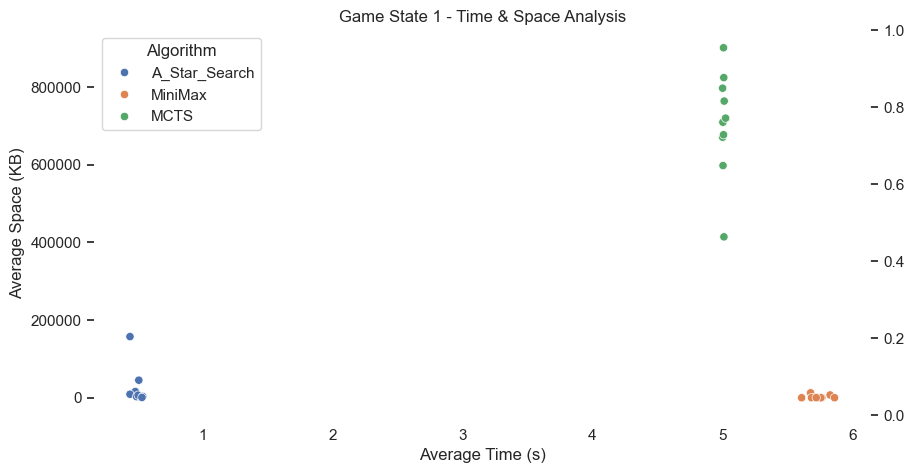

In [19]:
# Analysing Game State 1
new_node = TreeNode(state=Connect_Four_State().read_state('./Game States/State_1.txt'))
nodes = Analyse_Game_State(new_node, 'Game State 1 - Time & Space Analysis')

As we can infer from the scatterplot shown above, these algorithms tend to have **different necessities** to operate properly. While the A* Search **does not need much time and memory** to compute a possible solution, the same does not happen with the **Adversarial Search Algorithms**. 

When comparing MiniMax against Monte Carlo Tree Search we can clearly visualize the **time and memory differencies** both algorithms have to generate a good solution. On one hand, Monte Carlo **does not need much time (around ~5s)** to compute an answer while MiniMax's search time depends on it's depth (Since we are using depth=5 we can infer that his search time revolves around the ~6s, which makes Monte Carlo's **search faster**). Moreover, since the **board is empty** there are more possibilities that MiniMax needs to consider when compared to a more **advanced board configuration** where the amount of possible moves is much lower.

In Addition, while MiniMax **does not need much memory** to generate a great solution, the Monte Carlos's approach not only needs to store all the visited nodes to determine the best upper confidence bound applied for trees during it's **Selection phase** but also needs to generate thousands upon thousands of nodes due to the iterations made during it's **Simulation / Rollout Phase**. Threfore, due to this memory necessities, it's clearly that Monte Carlo Tree Search has a **greater Space Complexity** than MiniMax.

In [20]:
# Evaluating the Quality of the Solutions
print("[INITIAL NODE]")
print(new_node,"\n")
print("[OBTAINED RESULTS]\n")
for i in range(len(nodes)):
    print("->", Algorithms[i].__name__)
    print(nodes[i], "\n")

[INITIAL NODE]
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
# ------------- # 

[OBTAINED RESULTS]

->  A_Star_Search
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X - - - - - - |
# ------------- # 

->  MiniMax
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - X - - - - |
# ------------- # 

->  MCTS
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - X - - - |
# ------------- # 



As we can observe from the solutions obtained, all the algorithms have **different behaviours upon an empty board**.

Firstly, the A* Search algorithm chooses to play on the left corner which resembles one of the **worst moves** that can be made when placing the initial piece in the board. By placing it in the corner, the algorithm will not be able to expand the sequence to the left which makes his **odds of winning the game much lower** when compared to playing the piece in one of the central spaces. 

Secondly, the MiniMax algorithm seems to adopt a much **bolder choice** compared to the A* Search. By inserting a piece in one of the middle columns it grants him the ability to expand the current sequence more freely. However, since it did not choose the middle column (which is the optimal solution), this algorithm **falls behind** on being the best when compared to the Monte Carlo Tree Search.

Finally, the Monte Carlo Tree Search chooses the **optimal solution**. By choosing the central column the algorithm will be **more capable** of creating 4-piece combinations since he can **expand** his current sequence on **both directions** which **increses** his **chances of winning** drastically.

<div align="center">

---
#### Game State 2
---
</div>

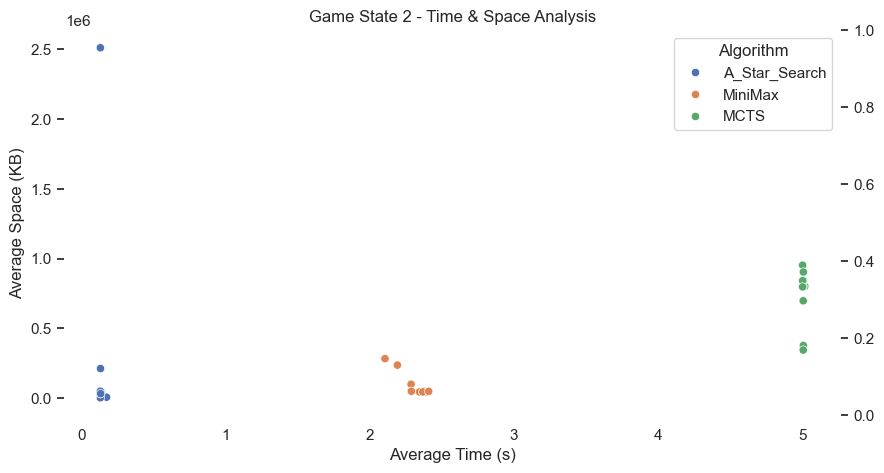

In [21]:
# Analysing Game State 2
new_node = TreeNode(state=Connect_Four_State().read_state('./Game States/State_2.txt'))
nodes = Analyse_Game_State(new_node, 'Game State 2 - Time & Space Analysis')

As we can see from this Scatterplot, the results obtained were **almost the exact same** as in  the previous game state. However there is a **significant decrease** on the MiniMax's search time. This decrease is most likely influenced by the fact that it **must block the opponent from winning** and therefore making the possible moves it can perform **drop** drastically making it much **faster** (around ~2s) during the decision making process.

In [22]:
# Evaluating the Quality of the Solutions
print("[INITIAL NODE]")
print(new_node,"\n")
print("[OBTAINED RESULTS]\n")
for i in range(len(nodes)):
    print("->", Algorithms[i].__name__)
    print(nodes[i], "\n")

[INITIAL NODE]
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X X X - - O O |
# ------------- # 

[OBTAINED RESULTS]

->  A_Star_Search
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - - - - - - |
| X X X - - O O |
# ------------- # 

->  MiniMax
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X X X O - O O |
# ------------- # 

->  MCTS
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| X X X O - O O |
# ------------- # 



By Observing the results given my the algorithms in this game state, we can easily analyse the **impact of performace** between **informed and adversarial** search strategies. As the results show, the A* Search (Simple Informed Search Algorithm) **neglects the other player' action**. This influences the algorithm to **ignore the opponent's existing 3-piece combination**. Consequently, by **not blocking** his opponent, the algorithm will most likely **lose** as the enemy finishes his 4-piece combination.

However, the same does not occur with the Adversarial Search Algorithms. In these results, both MiniMax and Monte Carlo Tree Search **take into consideration the enemy's next move**. Therefore, they try to minimize the opponent's score while maximizing his own, which leads them to **block** him from making a 4-piece sequence and win the game. By performing this action, both algorithms **prevent the game from finishing** allowing them to keep playing and seeking a better score in order to **win the game**.

<div align="center">

---
#### Game State 3
---
</div>

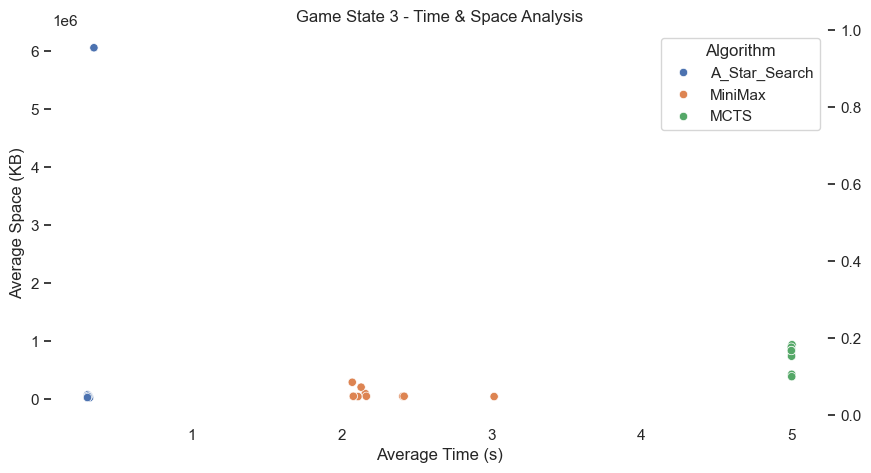

In [23]:
# Analysing Game State 3
new_node = TreeNode(state=Connect_Four_State().read_state('./Game States/State_3.txt'))
nodes = Analyse_Game_State(new_node, 'Game State 3 - Time & Space Analysis')

Once again the results transposed to this Scatterplot were **almost the exact same** as in the previous game state. 

One more time we can visualize a **significant decrease** of the MiniMax's search time (compared to it' search time in the Game State 1). This decrease most likely comes from the **need to block the opponent from winning**. Consequently the amount of possible moves **drops** drastically which makes the search much **faster** (around ~2s) during the decision making process.

In [33]:
# Evaluating the Quality of the Solutions
print("[INITIAL NODE]")
print(new_node,"\n")
print("[OBTAINED RESULTS]\n")
for i in range(len(nodes)):
    print("->", Algorithms[i].__name__)
    print(nodes[i], "\n")

[INITIAL NODE]
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O X - - - |
| X X O O X O - |
# ------------- # 

[OBTAINED RESULTS]

-> A_Star_Search
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O X - - - |
| X X O O X O O |
# ------------- # 

-> MiniMax
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O X - - - |
| X X O O X O - |
# ------------- # 

-> MCTS
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O O - - - |
| X X O O X O - |
# ------------- # 



In [39]:
new_node = TreeNode(state=Connect_Four_State().read_state('./Game States/State_3.txt'))
node = MCTS(new_node, heuristic_suggested)
print(node)

# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O O - - - |
| X X O O X O - |
# ------------- #
# ------------- #
| - - - - - - - |
| - - - - - - - |
| - - - - - - - |
| O - X X - - - |
| O X O O - - - |
| X X O O X O - |
# ------------- #


<div align="center">

---
### Adversarial Analysis
---
</div>

Since this Assignment also focuses on **adversarial strategy implementation**, we considered that conducting an **Adversarial Analysis** to evaluate how well the algorithms perform **against each other** or against known strategies would be quite insightful. This includes **analyzing situations** where one algorithm consistently outperforms the other.

In [25]:
# Initializing an instance of the class that allows us to Analyse the algorithms in action
Analysis = Connect_Four_Terminal_APP()

# Defining the amount of games to be considered in the Evaluation
number_games = 10

In [26]:
# Random Moves VS Random Moves
results = Analysis.run_multiple_games(number_games, Analysis.random, Analysis.random, None, None, False)
Analysis.show_multiple_games_results("Random 1", "Random 2", results, number_games)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> Random 1 	WON 5 MATCHES
-> Random 2 	WON 5 MATCHES
-> THERE WERE 	0 TIES

#-------------------#
| TOTAL MATCHES: 10 |
#-------------------#


When both algorithms execute **random moves** against each other it is predictable that they might end up **losing as much as winning**. Moreover, since it' decision making relies only upon the **generation of pseudo-random numbers** we can only conclude that this kind of moves are **not very reliable** when playing against a person.

In [27]:
# Random Moves VS A* Search
results = Analysis.run_multiple_games(number_games, Analysis.random, Analysis.A_Star, None, heuristic_suggested, False)
Analysis.show_multiple_games_results("Random", "A* Search", results, number_games)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> Random 	WON 6 MATCHES
-> A* Search 	WON 4 MATCHES
-> THERE WERE 	0 TIES

#-------------------#
| TOTAL MATCHES: 10 |
#-------------------#


As expected the A* Search algorithm **outperforms** random moves approach despite not winning all the games. This Analysis helps conclude that **having information** regarding the actual state of the game and how far it is from a solution can **greatly impact the peformance** of a algorithm.

In [28]:
# Random Moves VS MiniMax Algorithm
results = Analysis.run_multiple_games(number_games, Analysis.random, Analysis.minimax, None, heuristic_suggested, False)
Analysis.show_multiple_games_results("Random", "MiniMax", results, number_games)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> Random 	WON 3 MATCHES
-> MiniMax 	WON 3 MATCHES
-> THERE WERE 	4 TIES

#-------------------#
| TOTAL MATCHES: 10 |
#-------------------#


Similarly to the previous case, the **MiniMax algorithm** still outperforms random moves. This is expected due to the fact that MiniMax not only uses a **informed search** (based on a heuristic) but also an **adversarial** one, which also makes it take into consideration the **next possible moves from the opponent** in order to optimize his own score along the playthrough of the match.

In [29]:
# Random Moves VS Monte Carlo Tree Search
results = Analysis.run_multiple_games(3, Analysis.random, Analysis.mcts, None, heuristic_suggested, False)
Analysis.show_multiple_games_results("Random", "MCTS", results, 3)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> Random 	WON 0 MATCHES
-> MCTS 	WON 3 MATCHES
-> THERE WERE 	0 TIES

#------------------#
| TOTAL MATCHES: 3 |
#------------------#


Monte Carlo Tree Search, as an **Adversarial Search Strategy** (like MiniMax), shows his evident superiority over the random moves approach by defeating it in every single match. Once again, it is shown how much an **informed and adversarial** aapproach can greatly influece this kind of algorithms.

In [30]:
# A* Search VS MiniMax
results = Analysis.run_multiple_games(5, Analysis.A_Star, Analysis.minimax, heuristic_suggested, heuristic_suggested, False)
Analysis.show_multiple_games_results("A* Search", "MiniMax", results, 5)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> A* Search 	WON 5 MATCHES
-> MiniMax 	WON 0 MATCHES
-> THERE WERE 	0 TIES

#------------------#
| TOTAL MATCHES: 5 |
#------------------#


In [31]:
# A* Search VS Monte Carlo Tree Search
results = Analysis.run_multiple_games(5, Analysis.A_Star, Analysis.mcts, heuristic_suggested, heuristic_suggested, False)
Analysis.show_multiple_games_results("A* Search", "MCTS", results, 5)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> A* Search 	WON 0 MATCHES
-> MCTS 	WON 5 MATCHES
-> THERE WERE 	0 TIES

#------------------#
| TOTAL MATCHES: 5 |
#------------------#


# -> FINISH HERE
By analysing both adversarial search strategies (MiniMax and Monte Carlo Tree Search) play against a informed search startegy (A* Search) we can easily identify the performance differences between them. 


# -> ADD NOTES

In [32]:
# MiniMax VS Monte Carlo Tree Search
results = Analysis.run_multiple_games(5, Analysis.minimax, Analysis.mcts, heuristic_suggested, heuristic_suggested, False)
Analysis.show_multiple_games_results("MiniMax", "MCTS", results, 5)

#-------------------------#
|   # Results Analysis    |
#-------------------------#

-> MiniMax 	WON 0 MATCHES
-> MCTS 	WON 5 MATCHES
-> THERE WERE 	0 TIES

#------------------#
| TOTAL MATCHES: 5 |
#------------------#


# -> Analyse these NOtes
By Analysing two different Adversarial Search Algorithms play against each other, we can visualize the absence of a evident better approach. Even though Monte Carlo's search won more matches than MiniMax we can only assume that it is due to the fact that monte carlo requires more computacional power that makes it's search evalution stronger than the MiniMax's. However, MiniMax still seems to be holding fairly well against Monte Carlo 

---


## -> ADD CONCLUSIONS

___
## Final Considerations

$\quad$If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Maximino Canhola](https://github.com/MaximinoCanhola) &#8594; `up201909805@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`